# **Sales Price Prediction**

## Objectives

* Fit and evaluate a classification model to predic house sales price.

## Inputs



## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot

## Additional Comments

* This file and its contents were inspired by and adapted from the Churnometer Walkthrough Project 2.  

---

### Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housing-prices/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housing-prices'

### Load Data

Load train dataset:

In [ ]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv"))

df.head(1)

Load test dataset:

### ML Pipeline with all data

#### ML pipeline for Data Cleaning and Feature Engineering

In [ ]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.impute import SimpleImputer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer 
import pandas as pd

selection_method = "cardinality"
corr_method = "spearman"

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("NumericMissingValueImputer", MeanMedianImputer(imputation_method='median',
                                                         variables=['1stFlrSF', 'LotArea', 'GrLivArea', 
                                                                    'MasVnrArea', 'OpenPorchSF'])),
        
        ("CategoricalMissingValueImputer", CategoricalImputer(imputation_method='frequent',
                                                              variables=['BsmtExposure', 'BsmtFinType1', 
                                                                         'GarageFinish', 'KitchenQual'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 
                                                                'GarageFinish', 'KitchenQual'])),
        
        ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
        
        ("NumericPowerTransform", vt.PowerTransformer(variables=['MasVnrArea'])),
        
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),
        
        ("feat_scaling", StandardScaler()),

        ("FinalImputer", SimpleImputer(strategy="mean")),

        ("feat_selection", SelectFromModel(model)),
        
        ("model", model),
        
    ])

    return pipeline_base





Custom Class for Hyperparameter Optimisation

In [6]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)


print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Grid Search CV - Sklearn

#### Use standard hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick GridSearch CV - Binary Classifier

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.700011,0.817882,0.872805,0.061695
0,LinearRegression,0.724596,0.799473,0.838508,0.039476
5,GradientBoostingRegressor,0.61232,0.767917,0.851737,0.086988
2,RandomForestRegressor,0.672088,0.7467,0.817748,0.060065
4,AdaBoostRegressor,0.602909,0.736827,0.793978,0.069768
6,XGBRegressor,0.516448,0.650623,0.751455,0.087641
1,DecisionTreeRegressor,0.488006,0.593247,0.723566,0.095517


The best model was ExtraTreesRegressor, achieved an average R2 score of 0.82.

#### Extensive Hyperparameter Optimization:

In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Define a more detailed parameter grid for ExtraTreesRegressor
param_grid_ext = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=PipelineOptimization(models_quick_search["ExtraTreesRegressor"]),
    param_distributions=param_grid_ext,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Fit the search
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best R2 Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   7.2s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   7.1s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   7.0s
[CV] END model__max_depth=20, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=200; total time=   6.5s
[CV] END model__max_depth=20, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=200; total time=   5.9s
[CV] END model__max_depth=20, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=200; total time=   6.7s
[CV] END model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200; total time=   6.0s
[CV] END model__max_depth=20, model

#### Evaluate Model on Test Data:

In [12]:
from sklearn.metrics import r2_score, mean_squared_error

# Predict on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R2 Score on Test Data:", r2)
print("Mean Squared Error on Test Data:", mse)


R2 Score on Test Data: 0.8086040808559977
Mean Squared Error on Test Data: 1321751501.3310375


#### Feature Importance Analysis:

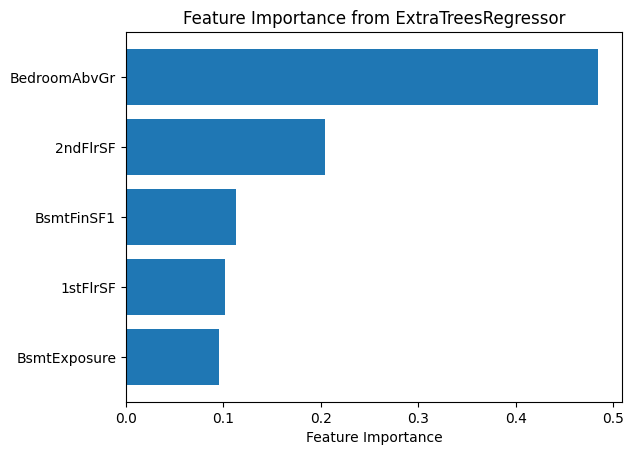

In [13]:
import matplotlib.pyplot as plt

# Extract feature importances
feature_importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Plot feature importances
sorted_idx = feature_importances.argsort()
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance from ExtraTreesRegressor")
plt.show()
